<a href="https://colab.research.google.com/github/hrbolek/simodes/blob/main/notebooks/examplesBcz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokročilé příklady použití simodes

In [472]:
!pip install simodes

## Pomocné funkce

In [473]:
import matplotlib.pyplot as plt     # for plots
import pandas as pd                 # for tables
import numpy as np                  # for matrices

from mpl_toolkits import mplot3d

plt.rcParams["figure.figsize"] = (12, 8)

### Jednoduchý 3D výstup

In [474]:
def plot3D(x, y, z, figure = None, showIt=True, **params):
    gph = figure
    if gph is None:
        gph = plt.figure(figsize=(15,8)).gca(projection='3d')

    gph.plot(x, y, z, **params)

    if showIt:
        plt.show()
    return gph

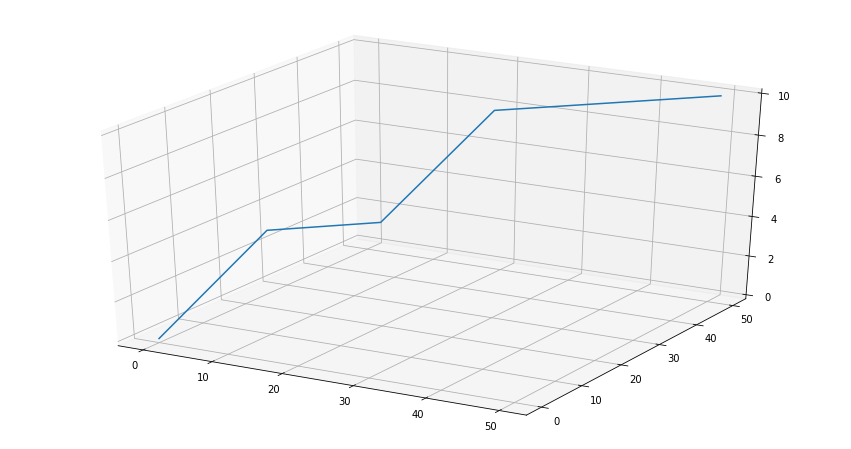

In [475]:
#=================#
# example of use  #
#=================#
x = [0, 10, 20, 30, 40, 50]
y = [0, 10, 20, 30, 40, 50]
z = [0, 5, 5, 10, 10, 10]
plot3D(x, y, z); # yes, semicolon has a meaning :)

### 3D výstup pro zpracování výsledků simulace

In [476]:
def plotData3D(rows, x='x', y='y', z='z', figure=None, showIt=True, **params):
    getx = lambda row: row[x]
    if callable(x):
        getx = x
    gety = lambda row: row[y]
    if callable(y):
        gety = y
    getz = lambda row: row[z]
    if callable(z):
        getz = z
    xx = []
    yy = []
    zz = []
    for row in rows:
        xx.append(getx(row))
        yy.append(gety(row))
        zz.append(getz(row))
    return plot3D(xx, yy, zz, figure, showIt, **params)

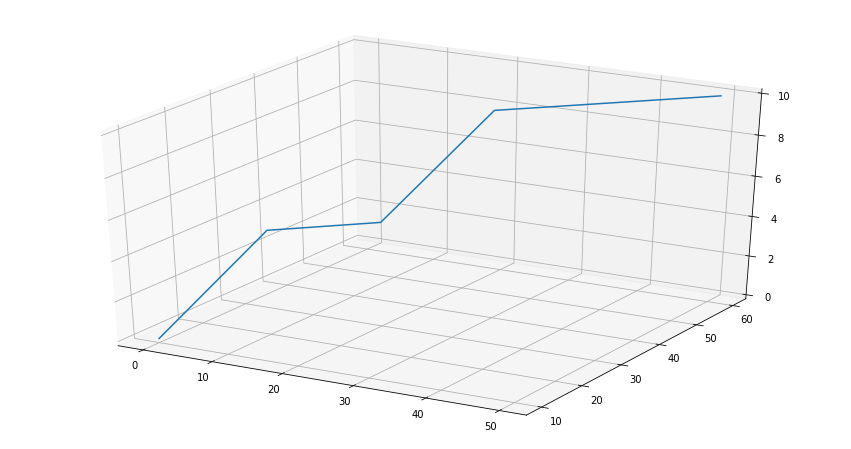

In [477]:
rows = [
    {'x': 0, 'y': 10, 'z': 0},
    {'x': 10, 'y': 20, 'z': 5},
    {'x': 20, 'y': 30, 'z': 5},
    {'x': 30, 'y': 40, 'z': 10},
    {'x': 40, 'y': 50, 'z': 10},
    {'x': 50, 'y': 60, 'z': 10}
]
plotData3D(rows);

## Příklad A

### Importy z knihovny 

In [478]:
import simodes
from simodes import Simulator
from simodes import simpleODESolver
from simodes import createDataSelector
from simodes.models import definePlane
from simodes.models import computeState

### Inicializace simulace

In [479]:
sim = Simulator()
currentState = sim.GetState()
print(currentState)

{'odeModels': {}, 'eventList': {'events': [], 'activeEvent': None}, 'logs': []}


### Příprava modelu

#### Cesta, kterou má letoun proletět

Cesta je definována jako pole souřadnic. Každá souřadnice má tři položky (x, y, z).

In [480]:
pathForPlaneList = [[10000, 250, 20], [5000, 125, 10], [0, 0, 0]]
pathForPlane = iter(pathForPlaneList)

#### Počáteční stav letounu

První tři parametry určují pozici, čtvrý parametr je rychlost, poslední dva parametry určují orientaci a sklon letounu.

In [481]:
planeState0 = computeState(12000, 600, 20, 100, 0, -3)

#### Model letounu

In [482]:
planeModel = definePlane(pathToFlyThrough=pathForPlane)
planeSolver = simpleODESolver(planeModel, 0, planeState0, 1e300, 0.0625)

#### Zavedení modelu do simulace

Získané ```planeId``` je identifikátorem, s jehož pomocí lze ze simulace vyčíst stav letounu.

In [483]:
planeId = sim.AttachODESolver(planeSolver)

### Příprava pro transformaci dat

In [484]:
masterMap = {
    'plane_': lambda item: item[planeId]
}

In [485]:
dataDescriptor = {
    't': lambda item: item['state']['time'],
    'x': lambda item: item['state']['y'][0],
    'y': lambda item: item['state']['y'][1],
    'z': lambda item: item['state']['y'][2]
}

Vytoření selektoru pro extrakci dat v cyklu simulace.

In [486]:
dataSelector = createDataSelector(masterMap, dataDescriptor)

### Cyklus simulace

Cyklus simulace implementovaný níže skončí, pokud letoun narazí do země (výška 0m), nebo pokud počet kroků dosáhne hodnoty 10 000.

V průběhu simulace jsou do proměnné results ukládána data, která jsou po ukončení simulace k dispozici. V tomto konkrétním případě se jedná o polohu letounu v čase.

In [487]:
results = []
for index, currentResult in enumerate(sim.Run()):
    partialResult = dataSelector(currentResult)
    results.append(partialResult)
    if index >= 10000:
        break
    if (partialResult['plane_z'] < 0):
      break

### Zpracování dat

Zobrazení dat v tabulce je samozřejmostí.

In [488]:
import pandas as pd

def displayData(data):
    df = pd.DataFrame(data)
    display(df)

In [489]:
displayData(results)

,plane_t,plane_x,plane_y,plane_z
0,0.000000,12000.000000,600.000000,20.000000
1,0.062500,11993.818220,599.079352,20.000000
2,0.125000,11987.648432,598.081505,20.000000
3,0.170996,11983.115609,597.300366,20.000000
4,0.216993,11978.584885,596.507120,20.000000
...,...,...,...,...
2054,114.850192,548.544097,13.610467,0.018820
2055,114.912692,542.296056,13.454116,0.012876
2056,114.975192,536.048015,13.297765,0.006932
2057,115.037692,529.799974,13.141414,0.000989


S využitím pomocných funkcí definovaných v první části tohoto dokumentu lze provést vizualizaci.

Modrnou plnou čarou je zobrazen let letounu. Čárkovanou modrou je zobrazen průmět do roviny xy. Červenou plnou čarou je zobrazena naplánovaná trasa. Červená čárkovaná je průmět plánované trasy do roviny xy.

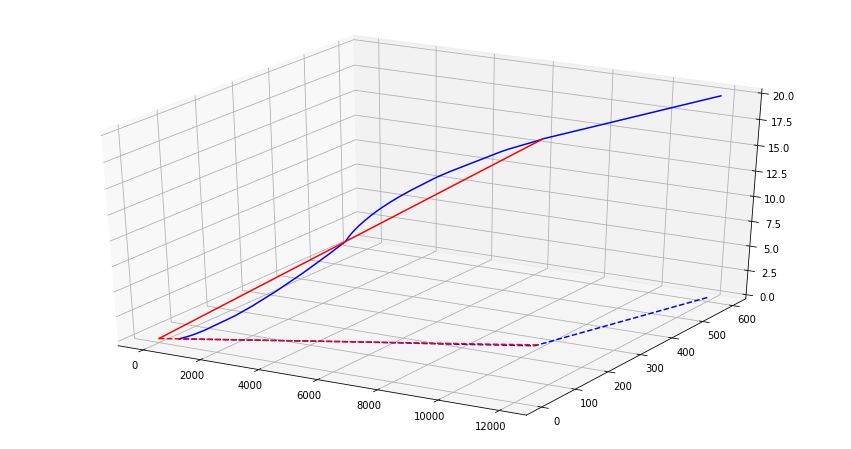

In [490]:
getpx = lambda row: row['plane_x']
getpy = lambda row: row['plane_y']
get0 = lambda row: 0

getPathx = lambda item: item[0]
getPathy = lambda item: item[1]
getPathz = lambda item: item[2]

fig = plotData3D(results, x='plane_x', y='plane_y', z='plane_z', color='blue', showIt=False)
plotData3D(results, x=getpx, y=getpy, z=get0, figure=fig, color='blue', ls='--', showIt=False)
plotData3D(pathForPlaneList, x=getPathx, y=getPathy, z=getPathz, figure=fig, color='red', showIt=False)
plotData3D(pathForPlaneList, x=getPathx, y=getPathy, z=get0, figure=fig, color='red', ls='--')